In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
import albumentations as A
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#Обработка данных

In [ ]:
from PIL import Image
import os

dataset_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

# Получим список подпапок в директории
subdirectories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Инициализируем переменные для хранения минимального и максимального размеров
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

# Пройдм по каждой подпапке и извлечь изображения, получим список файлов изображений в текущей подпапке и пройдм по каждому изображению и получить его размеры
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(dataset_path, subdirectory)

    image_files = [f for f in os.listdir(subdirectory_path) if f.endswith(('tif', '.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        image_path = os.path.join(subdirectory_path, image_file)
        with Image.open(image_path) as img:
            width, height = img.size
            # Обновим минимальные и максимальные размеры
            min_width = min(min_width, width)
            min_height = min(min_height, height)
            max_width = max(max_width, width)
            max_height = max(max_height, height)


print("Минимальные размеры:", min_width, "x", min_height)
print("Максимальные размеры:", max_width, "x", max_height)


Минимальные размеры: 256 x 256
Максимальные размеры: 256 x 256


In [ ]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

In [ ]:
from PIL import Image
import os

dataset_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

# Переменная для отслеживания флага обнаружения изображений с неправильной глубиной цвета
incorrect_bit_depth_found = False

# Проходим по каждому изображению в датасете, проверяем является ли режим изображения 16-битным RGB
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('tif', '.jpg', '.jpeg', '.png')) and 'mask' not in file:
            image_path = os.path.join(root, file)

            with Image.open(image_path) as img:

                if img.mode == 'RGB;16':
                    print(f"Изображение {image_path} имеет глубину цвета 16 бит на канал.")
                    incorrect_bit_depth_found = True


if not incorrect_bit_depth_found:
    print("Все изображения имеют правильную глубину цвета (не более 8 бит на канал), либо отсутствуют изображения RGB;16.")


Все изображения имеют правильную глубину цвета (не более 8 бит на канал), либо отсутствуют изображения RGB;16.


In [ ]:
from PIL import Image
import os

dataset_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

# Переменная для отслеживания флага обнаружения масок с неправильным форматом,
incorrect_mask_format_found = False

# Проходим по каждой маске в датасете, проверяем, является ли формат маски "L" (8 бит на пиксель)
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if 'mask' in file and file.endswith(('tif', '.jpg', '.jpeg', '.png')):
            mask_path = os.path.join(root, file)
            # Открываем маску
            with Image.open(mask_path) as mask_img:

                if mask_img.mode != 'L':
                    print(f"Маска {mask_path} имеет неправильный формат {mask_img.mode}. Ожидается формат 'L'.")
                    incorrect_mask_format_found = True


if not incorrect_mask_format_found:
    print("Все маски имеют правильный формат ('L').")


Все маски имеют правильный формат ('L').


In [ ]:
#Cобираv информацию о директориях и путях к файлам для дальнейшей обработки в пандас
# Проходим по всем поддиректориям в указанном пути, иИзвлекаем имя текущей директории
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        # Извлекаем имя текущей директории
        dir_name = sub_dir_path.split('/')[-1]
        # Проходим по всем файлам в текущей директории
        for filename in os.listdir(sub_dir_path):
            # Формируем полный путь к файлу,  добавляем информацию о директории и файле в список
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [ ]:
#Заводим Датафреймы с пустями с маской и без
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 89
END_IMG_LEN = 4 # .tiff
END_MASK_LEN = 9 # _mask.tiff
# Сортируем изображния и маски по айди пациента
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70_mask.tif


In [ ]:
#Создаем итоговый датасет для дальнейшей работы, проверям пустая ли маска и расставляем соответственно метки
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
...                                                 ...   ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  

[3929 rows x 4 columns]

In [ ]:
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

#Визуализация



In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index,
                        y=brain_df['mask'].value_counts(),
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

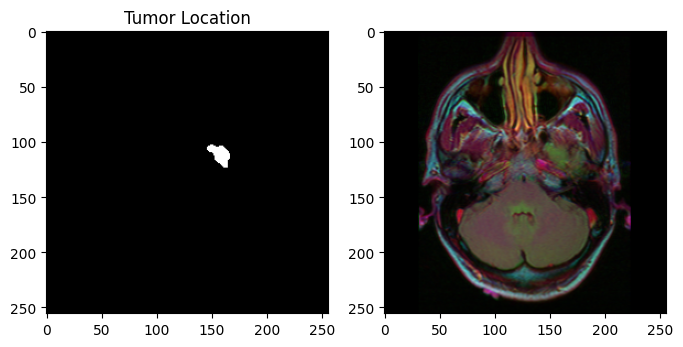

In [ ]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [ ]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

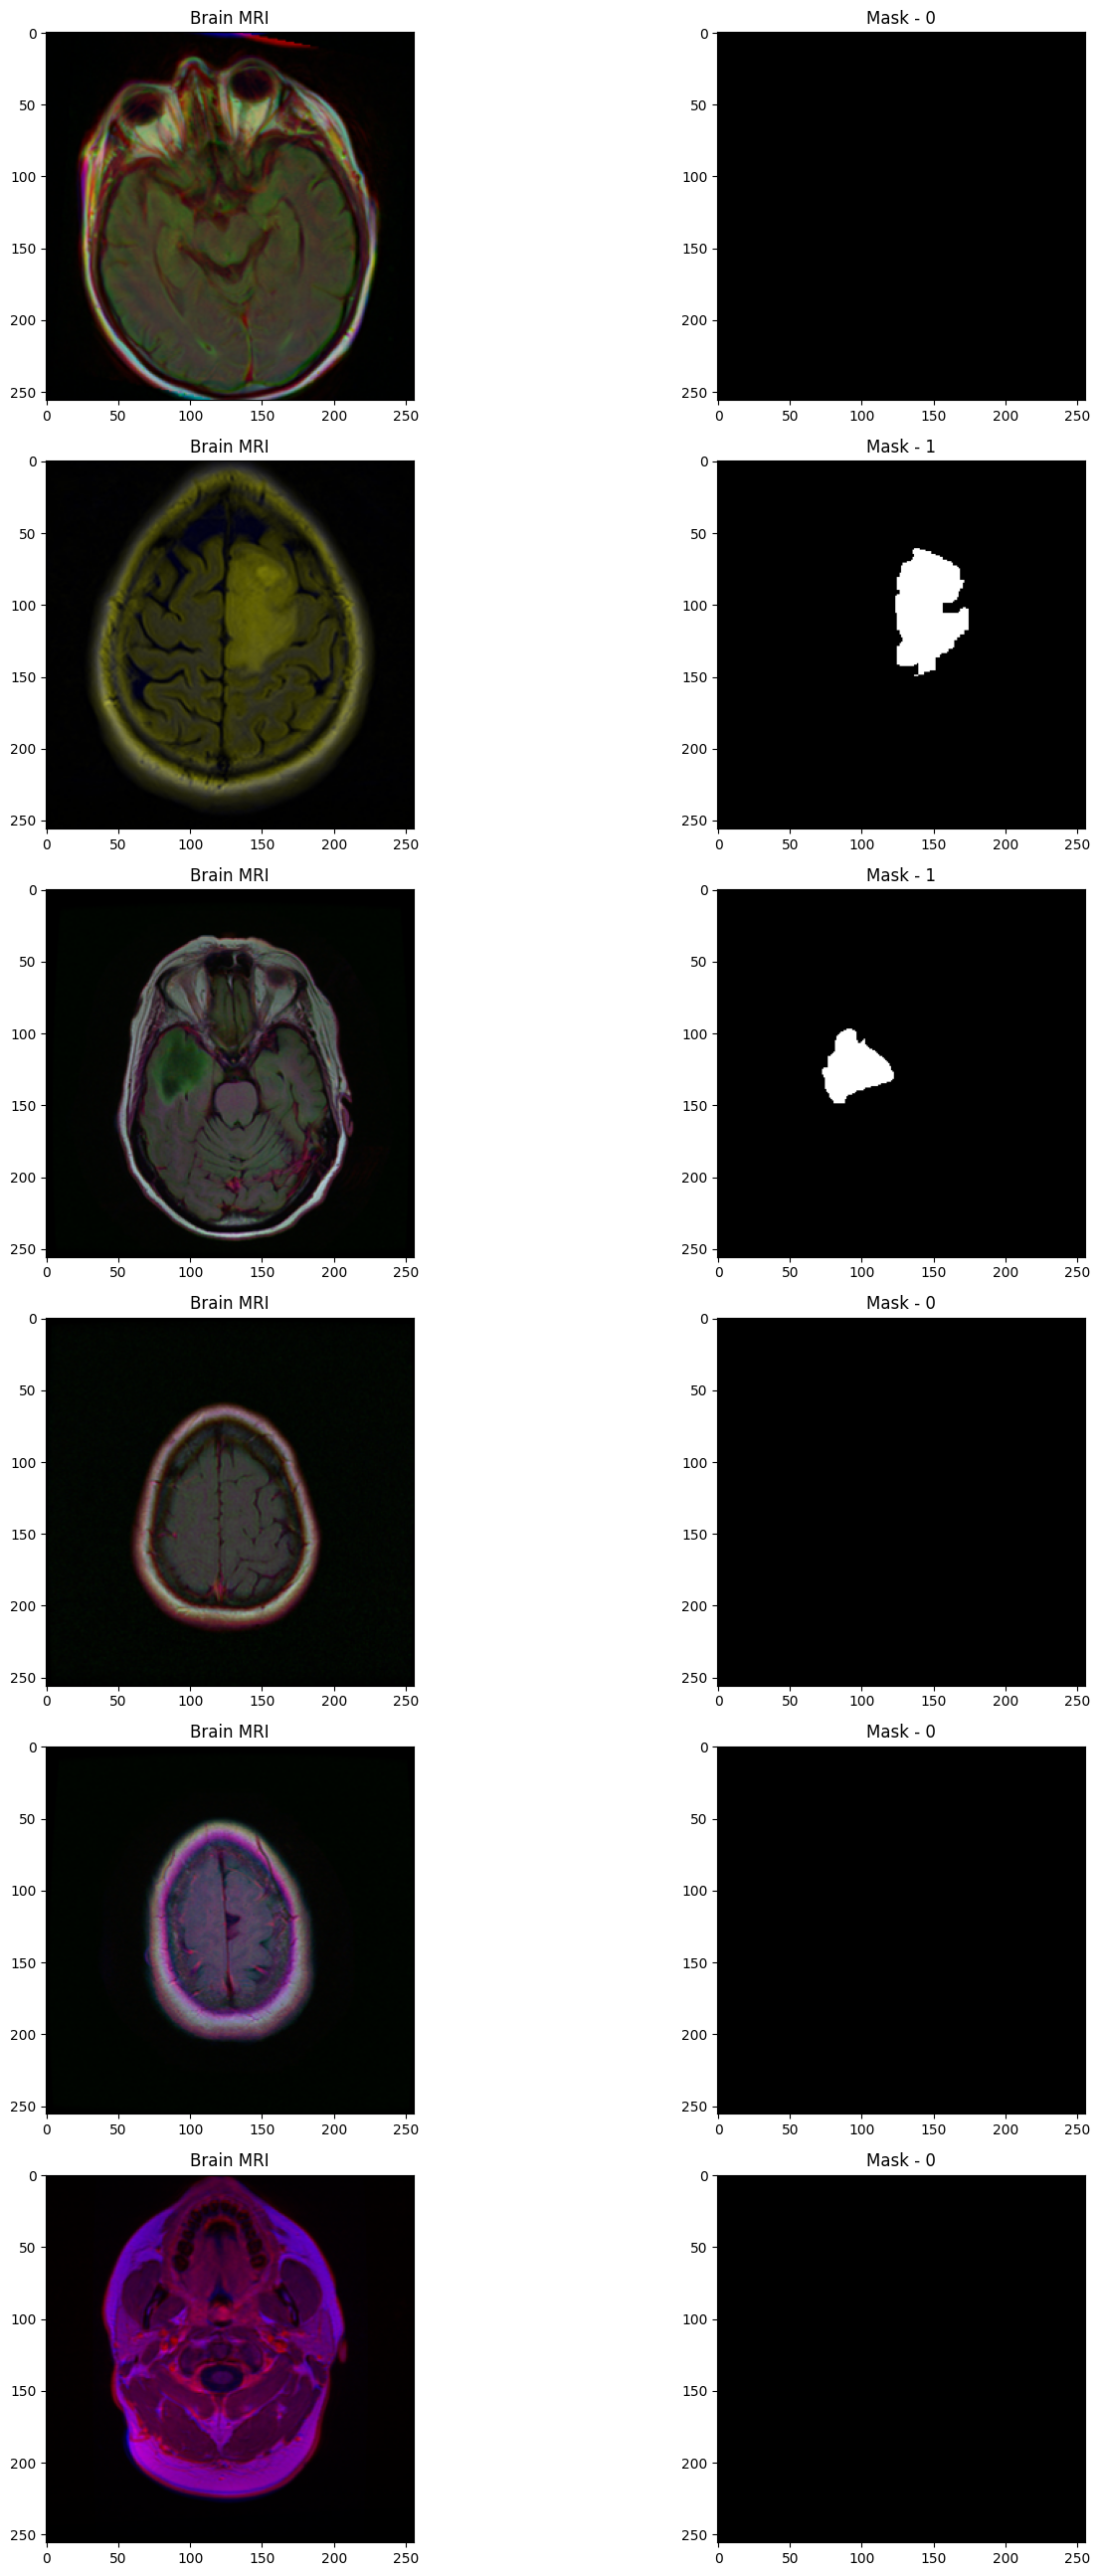

In [ ]:
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1

fig.tight_layout()

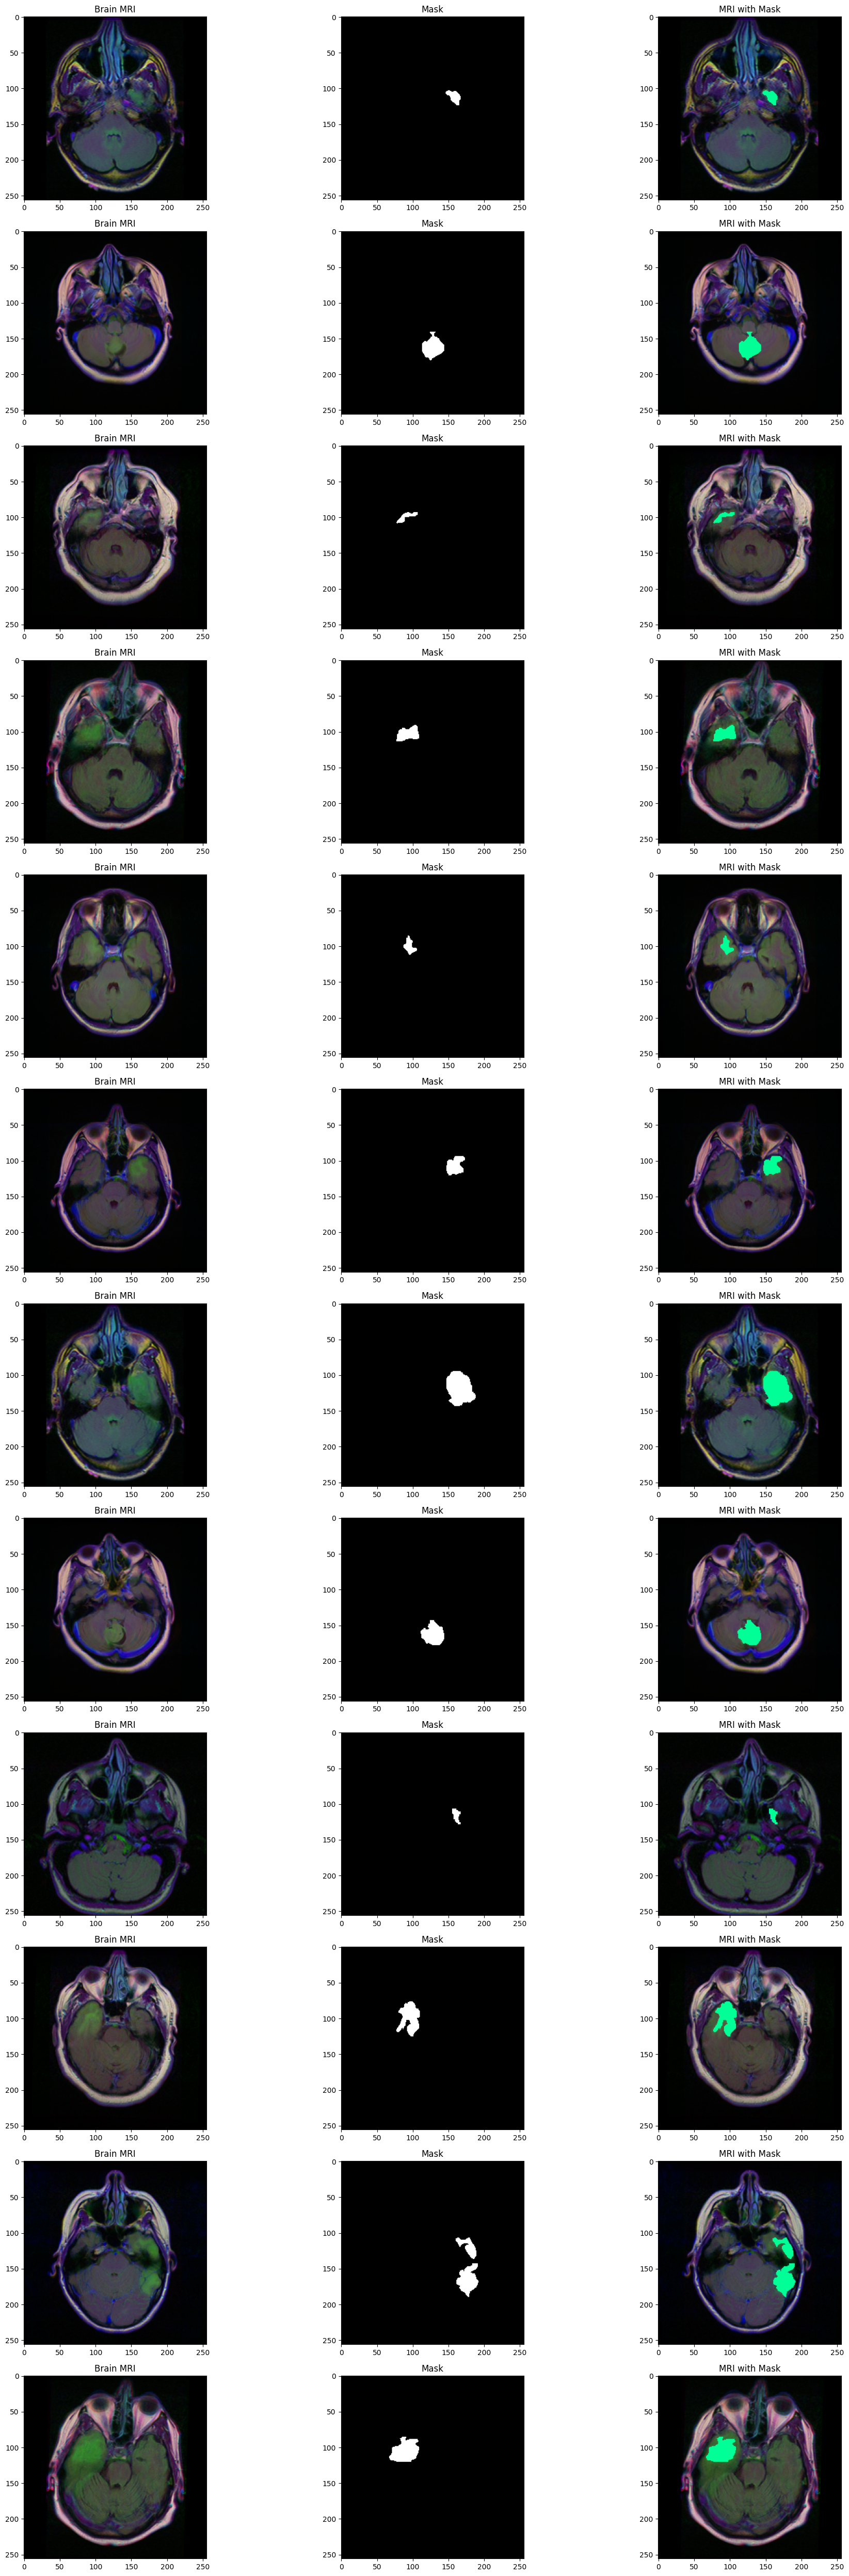

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split
#Разбиваем выборку на обучающую и тестовую
train, test = train_test_split(brain_df_train, test_size=0.15)

In [ ]:
import cv2
import numpy as np
import pandas as pd #
pd.options.mode.chained_assignment = None  # default='warn'
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
from sklearn import metrics

In [ ]:
 def plot_confusion_matrix(y,my_predict):
    "this function plots the confusion matrix"
    cm = confusion_matrix(y, my_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['No Tumor', 'Tumor Detected']); ax.yaxis.set_ticklabels(['No Tumor', 'Tumor Detected'])
    tn, fp, fn, tp = metrics.confusion_matrix(y, my_predict).ravel()
    specificity = (tn/(tn+fp))*100
    print(f'Accuracy:{round(metrics.accuracy_score(y, my_predict)*100,2)}%')
    print('Recall:', (metrics.recall_score(y, my_predict)*100), '%')
    print('Precision:', (metrics.precision_score(y, my_predict)*100), '%')
    print('f1:', (metrics.f1_score(y, my_predict)*100), '%')
    print('jaccard_score:', (metrics.jaccard_score(y, my_predict)*100), '%')
    print('Specificity:', specificity, '%')
    print("Confusion Matrix: \n", metrics.confusion_matrix(y, my_predict))


In [ ]:
pip install keras_preprocessing

  Obtaining dependency information for keras_preprocessing from https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


#Создаем генераторы с нормализацей

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


#Дообучение и работа с гиперпараметрами ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
#clf_model.summary()

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = BatchNormalization()(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model0 = Model(clf_model.input, head)
model0.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics= ["accuracy"]
              )


In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=50
                             )
checkpointer = ModelCheckpoint(monitor = 'val_acc',
                               filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, reduce_lr]



In [ ]:
h = model0.fit(train_generator,
              steps_per_epoch= train_generator.n // train_generator.batch_size,
              epochs = 50,
              validation_data= valid_generator,
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks=callbacks)

Epoch 1/50
187/187 [==============================] - 65s 144ms/step - loss: 0.6070 - accuracy: 0.7191 - val_loss: 2.1296 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 2/50
187/187 [==============================] - 24s 130ms/step - loss: 0.6648 - accuracy: 0.6829 - val_loss: 2.4640 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 3/50
187/187 [==============================] - 24s 130ms/step - loss: 0.5482 - accuracy: 0.7488 - val_loss: 0.6273 - val_accuracy: 0.6781 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - 24s 130ms/step - loss: 0.4644 - accuracy: 0.8030 - val_loss: 0.6699 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 5/50
187/187 [==============================] - 24s 130ms/step - loss: 0.3744 - accuracy: 0.8381 - val_loss: 0.6619 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/50
187/187 [==============================] - 24s 130ms/step - loss: 0.3479 - accuracy: 0.8485 - val_loss: 0.3786 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 7/50
187/187 [==============================] 

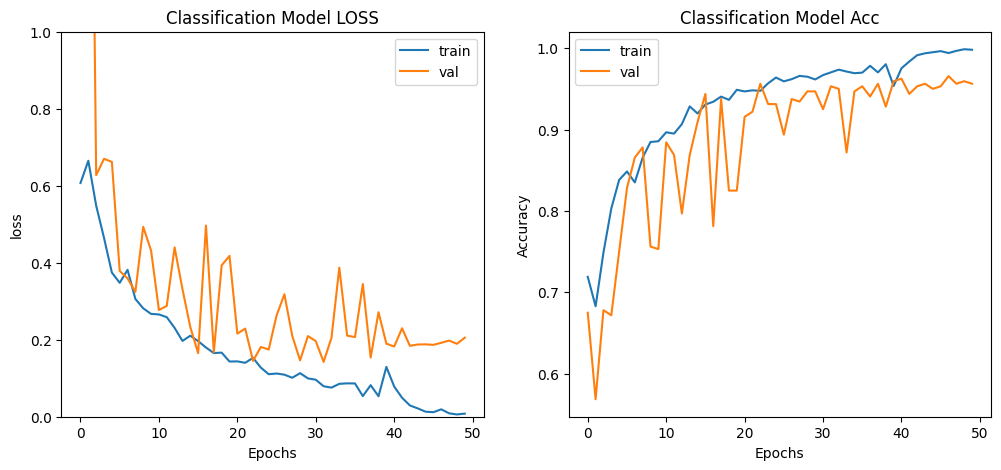

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.ylim(top=1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

37/37 [==============================] - 2s 59ms/step - loss: 0.1176 - accuracy: 0.9712
Test accuracy : 97.11864590644836 %
37/37 [==============================] - 3s 44ms/step
0.9711864406779661
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       399
           1       0.93      0.98      0.96       191

    accuracy                           0.97       590
   macro avg       0.96      0.97      0.97       590
weighted avg       0.97      0.97      0.97       590



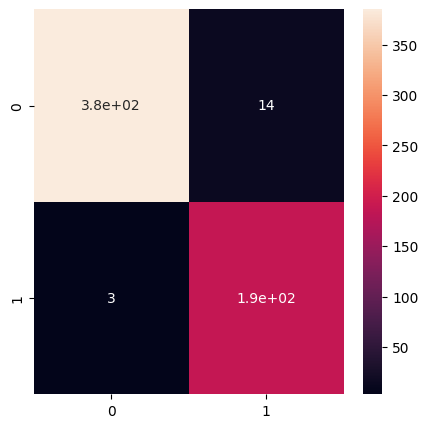

In [ ]:
_, acc = model0.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

prediction = model0.predict(test_generator)

pred = np.argmax(prediction, axis=1)
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);


Accuracy:97.12%
Recall: 93.06930693069307 %
Precision: 98.42931937172776 %
f1: 95.67430025445293 %
jaccard_score: 91.70731707317074 %
Specificity: 99.22680412371135 %
Confusion Matrix: 
 [[385   3]
 [ 14 188]]


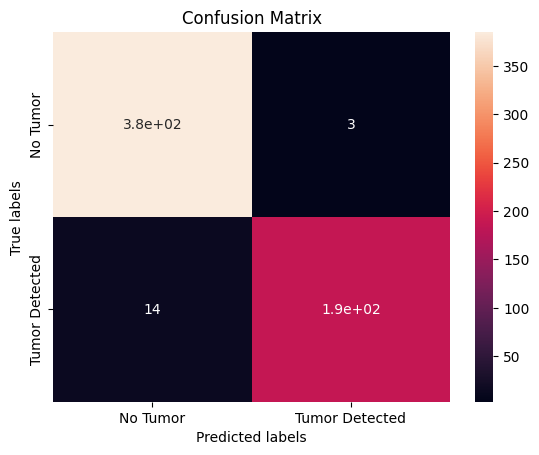

In [ ]:
plot_confusion_matrix(pred, original)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
head = clf_model.output
head = AveragePooling2D(pool_size=(3,3))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = BatchNormalization()(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics= ["accuracy"]
             )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              #patience=15
                             )
checkpointer = ModelCheckpoint(monitor = 'val_acc',
                               filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, reduce_lr]

In [ ]:
h_0 = model.fit(train_generator,
              steps_per_epoch= train_generator.n // train_generator.batch_size,
              epochs = 50,
              validation_data= valid_generator,
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks=callbacks)

Epoch 1/50
187/187 [==============================] - 59s 136ms/step - loss: 0.6636 - accuracy: 0.7144 - val_loss: 2.3088 - val_accuracy: 0.6781 - lr: 0.0010
Epoch 2/50
187/187 [==============================] - 24s 130ms/step - loss: 0.5144 - accuracy: 0.7686 - val_loss: 0.7024 - val_accuracy: 0.6781 - lr: 0.0010
Epoch 3/50
187/187 [==============================] - 24s 130ms/step - loss: 0.5202 - accuracy: 0.7779 - val_loss: 0.6657 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - 24s 130ms/step - loss: 0.5536 - accuracy: 0.7562 - val_loss: 2.3187 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 5/50
187/187 [==============================] - 25s 131ms/step - loss: 0.4694 - accuracy: 0.7846 - val_loss: 0.4320 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 6/50
187/187 [==============================] - 25s 131ms/step - loss: 0.4048 - accuracy: 0.8241 - val_loss: 0.3697 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 7/50
187/187 [==============================] 

In [ ]:
h_0.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

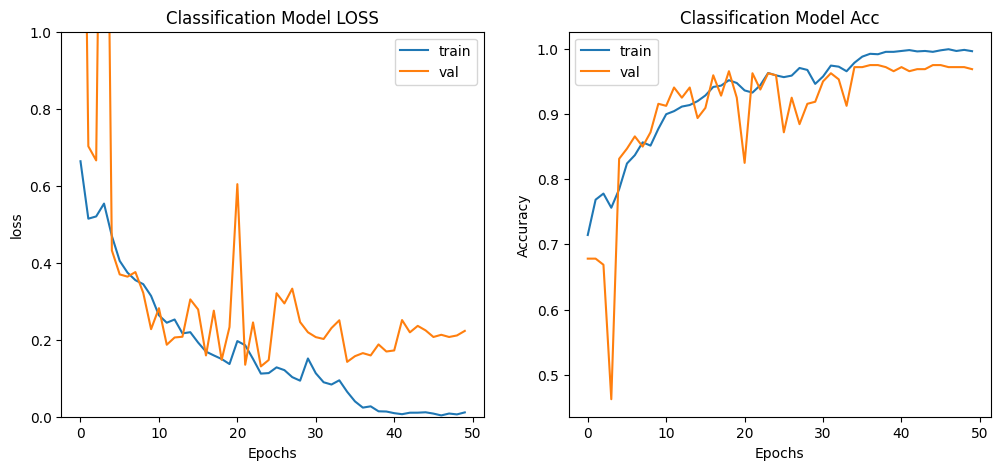

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.ylim(top=1)
plt.plot(h_0.history['loss']);
plt.plot(h_0.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h_0.history['accuracy']);
plt.plot(h_0.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 62ms/step - loss: 0.1116 - accuracy: 0.9780
Test accuracy : 97.79661297798157 %


37/37 [==============================] - 3s 46ms/step
0.9779661016949153
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       399
           1       0.97      0.96      0.97       191

    accuracy                           0.98       590
   macro avg       0.98      0.97      0.97       590
weighted avg       0.98      0.98      0.98       590



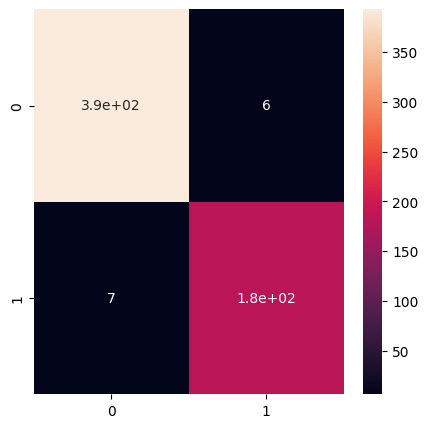

In [ ]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

Accuracy:97.8%
Recall: 96.84210526315789 %
Precision: 96.33507853403141 %
f1: 96.58792650918635 %
jaccard_score: 93.4010152284264 %
Specificity: 98.25 %
Confusion Matrix: 
 [[393   7]
 [  6 184]]


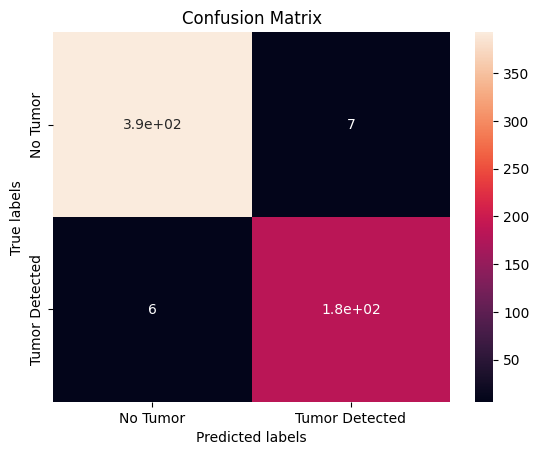

In [ ]:
plot_confusion_matrix(pred, original)

In [ ]:
import cv2
import numpy as np

def custom_preprocessing(image):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  sigma = np.random.uniform(0, 2)
  kernel_size = int(2 * round(3 * sigma) + 1)
  image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
  #flip_code = np.random.choice([-1, 0, 1])
  #image = cv2.flip(image, flip_code)
  kernel = np.array(
    [[-1, -1, -1],
     [-1,  9, -1],
     [-1, -1, -1]], dtype=np.float32
  )
  image = cv2.filter2D(image, -1, kernel)
  image = np.clip(image, 0, 255)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image


In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing,rescale=1./255., validation_split=0.1,
                            )

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )


Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = BatchNormalization()(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model1 = Model(clf_model.input, head)
model1.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics= ["accuracy"]
             )
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
model1.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics= ["accuracy"]
             )
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              #patience=15
                             )
checkpointer = ModelCheckpoint(monitor = 'val_acc',
                               filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, reduce_lr]

In [ ]:
h_01 = model1.fit(train_generator,
              steps_per_epoch= train_generator.n // train_generator.batch_size,
              epochs = 50,
              validation_data= valid_generator,
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks=callbacks)

Epoch 1/50
187/187 [==============================] - 60s 138ms/step - loss: 0.6183 - accuracy: 0.7157 - val_loss: 0.6555 - val_accuracy: 0.6844 - lr: 0.0010
Epoch 2/50
187/187 [==============================] - 25s 132ms/step - loss: 0.5965 - accuracy: 0.7174 - val_loss: 0.6416 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 3/50
187/187 [==============================] - 25s 132ms/step - loss: 0.5109 - accuracy: 0.7538 - val_loss: 0.9528 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - 25s 134ms/step - loss: 0.5228 - accuracy: 0.7448 - val_loss: 0.6307 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/50
187/187 [==============================] - 25s 134ms/step - loss: 0.4631 - accuracy: 0.7779 - val_loss: 0.4196 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 6/50
187/187 [==============================] - 25s 132ms/step - loss: 0.3943 - accuracy: 0.8043 - val_loss: 0.3767 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 7/50
187/187 [==============================] 

In [ ]:
model1_json = model.to_json()
with open("/kaggle/working/clf-resnet-model_01.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model1.save('/kaggle/working/clf-resnet-model_01.keras')

In [ ]:
import os

file_list = os.listdir('/kaggle/working')


print(file_list)
